In [16]:
import numpy as np
from nodes.nodes import FoldiakNode, InputNode
from nodes.net import FoldiakShapedNet
from nodes.layer import ShapedLayer

import random
import matplotlib.pyplot as plt
from math import sqrt

random.seed(7)

inputlayer = ShapedLayer((8,8))
foldiaklayer = ShapedLayer(16)


foldiaklayer.fillnodes(FoldiakNode, 0.5)
inputlayer.fillnodes(InputNode)
    
network = FoldiakShapedNet()
network.append(inputlayer)
network.append(foldiaklayer)
network.connect_foldiak(inputlayer, foldiaklayer)

network.setparam("intmethod","LSODA")
#network.setparam("p",1.0/8)
network.setparam("p",p)
network.setparam("l",10)
network.setparam("tmax",100)

In [17]:
network.setup()
network.setup()

In [4]:
samples = np.loadtxt("../data/lines_keyed.csv")
keys = np.loadtxt("../data/lines_keys.csv")

In [18]:
np.sum(np.square(network.cgroups[0].getbiases()[0]))

0.9999999999999999

In [19]:
#Steady state thres:
network.setparam("a",0.0)
network.setparam("b",0.0)
network.setparam("y",0.0)
#network.setparam("y",0.5)
for i in range(200):
    for i in inputlayer.nodes:
        i.setvalstored(random.uniform(0,1))
    network.update()

In [20]:
network.setparam("a",0.1)
network.setparam("b",0.02)
network.setparam("y",0.0)
#network.setparam("y",0.02)

In [21]:
possibletypes = []
for i in range(8):
    sample = np.zeros((8,8))
    sample[i,:] = 1
    possibletypes.append(sample)
for i in range(8):
    sample = np.zeros((8,8))
    sample[:,i] = 1
    possibletypes.append(sample)

In [23]:
key_errors = []
mem_errors = []
inh_means  = []
inh_stds   = []
inh_mins   = []
inh_maxes  = []

inh_biases = []
for_biases = []
threses    = []

startnum = 0
for i in range(1):
    for startnum in range(25):

        permutation = [0,0,0,0,0,0,0,0,
                       0,0,0,0,0,0,0,0]
        outimages = []

        for j in range(16):
            lowestmin = 64
            outimage = np.zeros((8,8))
            goestonum = 0
            tnum = 0
            for i in possibletypes:
                mem = np.reshape(network.cgroups[0].getbiases()[:,j],(8,8))
                mem = mem/mem.max()
                er = np.sum(np.abs(mem - i))
                #print(er)
                if (er < lowestmin):
                    lowestmin = er
                    outimage = np.abs(mem-i)
                    goestonum = tnum
                tnum += 1
            outimages.append(outimage)
            permutation[goestonum] = j
        ersum = 0
        for i in outimages:
            ersum += np.sum(i)
        mem_errors.append(ersum/(8*8*16))



        output_keys = np.zeros((1000,16))

        idx = np.empty_like(permutation)
        idx[permutation] = np.arange(len(permutation))

        test_keys_this = keys[startnum*1000:startnum*1000+1000, idx]
        test_samples_this = samples[startnum*1000:startnum*1000+1000]
        for i in range(1000):
            inputlayer.setvals(test_samples_this[i,:])
            network.update()
            #network.cgroups[0].normbiases()
            output_keys[i,:] = foldiaklayer.returnvals()
            #if (i%1000)==999:
                #print(str(i+1)+"/"+str(25000))

        key_errors.append(np.sum(np.abs(test_keys_this-output_keys))/np.sum(test_keys_this))

        inh_means.append(network.cgroups[1].getbiases().mean())
        inh_stds.append(network.cgroups[1].getbiases().std())
        inh_mins.append(network.cgroups[1].getbiases().min())
        inh_maxes.append(network.cgroups[1].getbiases().max())

        inh_biases.append(network.cgroups[1].getbiases())
        for_biases.append(network.cgroups[0].getbiases())

        threses.append(foldiaklayer.returnthres())

        if (startnum==-1):
            fig=plt.figure()

            for node_num in range(len(foldiaklayer.nodes)):
                testbias = []
                connects = np.reshape(network.cgroups[0].npconnects, -1)
                for node in inputlayer.nodes:
                    for i in connects:
                        if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                            testbias.append(i.bias)
                fig.add_subplot(4,4,node_num+1)

                plt.imshow(np.array(testbias).reshape((8,8)))
            fig.tight_layout()
            #plt.savefig("2020_07_07_bias_figure.png")
            plt.show()

            plt.imshow(np.abs(test_this_keys-output_keys))
            plt.show()

        if ((startnum+1)%5)==0:
            print("Finished: " + str(startnum+1))

Finished: 5
Finished: 10
Finished: 15
Finished: 20
Finished: 25


In [15]:
key_errors_nothres = [i for i in key_errors]

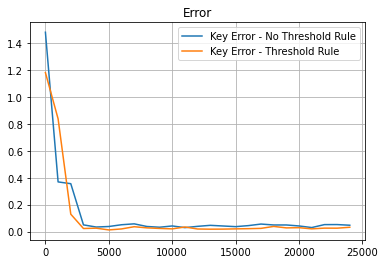

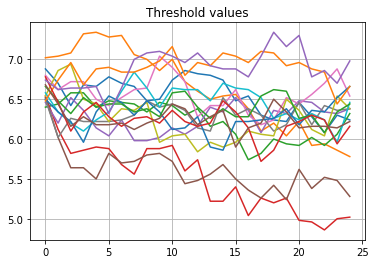

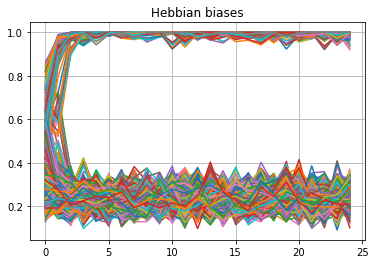

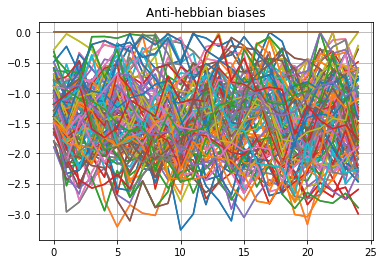

In [25]:
plt.plot([i*1000 for i in range(len(key_errors_nothres))], key_errors_nothres, label='Key Error - No Threshold Rule')
plt.plot([i*1000 for i in range(len(key_errors))], key_errors, label='Key Error - Threshold Rule')
#plt.plot([i*1000 for i in range(len(mem_errors))], mem_errors, label='Learned Memory Error')
plt.legend()
plt.grid()
plt.title("Error")
plt.savefig("images/2020_07_15_LEB_error_no_thres_update.png")
plt.show()
plt.plot(threses)
plt.grid()
plt.title("Threshold values")
#plt.savefig("2020_07_11_LEB_wrong_thres_thresh_graph.png")
plt.show()
for n in range(16):
    plt.plot([i[:,n] for i in for_biases])
plt.grid()
plt.title("Hebbian biases")
#plt.savefig("2020_07_11_LEB_wrong_thres_for_bias_graph.png")
plt.show()
for n in range(16):
    plt.plot([i[:,n] for i in inh_biases])
plt.grid()
plt.title("Anti-hebbian biases")
#plt.savefig("2020_07_11_LEB_wrong_thres_inh_bias_graph.png")
plt.show()

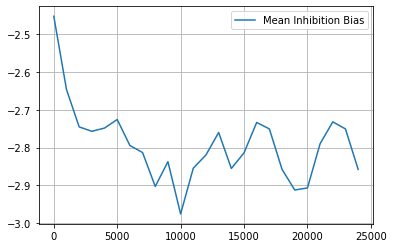

In [14]:
plt.plot([i*1000 for i in range(len(inh_means))], inh_means, label='Mean Inhibition Bias')
#plt.plot([i*1000 for i in range(len(inh_stds))], inh_stds, label='Standard Deviation of Inhibition Bias')
#plt.plot([i*1000 for i in range(len(inh_mins))], inh_mins, label='Minimum Inhibition Bias')
#plt.plot([i*1000 for i in range(len(inh_maxes))], inh_maxes, label='Maximum Inhibition Bias')
plt.legend()
plt.grid()
plt.savefig("images/2020_07_15_LEB_inhib_no_thres_update.png")
plt.show()

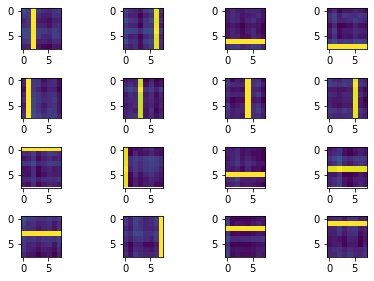

In [11]:
fig=plt.figure()

for node_num in range(len(foldiaklayer.nodes)):
    testbias = []
    connects = np.reshape(network.cgroups[0].npconnects, -1)
    for node in inputlayer.nodes:
        for i in connects:
            if (i.input is node) and (i.output is foldiaklayer.nodes[node_num]):
                testbias.append(i.bias)
    fig.add_subplot(4,4,node_num+1)
            
    plt.imshow(np.array(testbias).reshape((8,8)))
fig.tight_layout()
plt.show()

In [11]:
permutation

[3, 11, 14, 15, 4, 9, 12, 8, 10, 13, 6, 7, 1, 5, 2, 0]

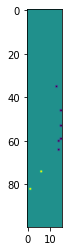

0.1325
0.128125


In [12]:
plt.imshow((test_keys_this-output_keys)[:100,:])
plt.show()

print(np.sum(output_keys)/16000)
print(np.sum(test_keys_this)/16000)

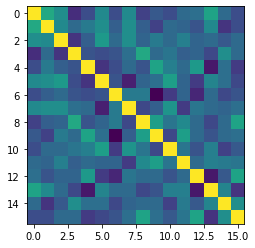

In [13]:
plt.imshow(network.cgroups[1].getbiases())
plt.show()

In [14]:
network.cgroups[1].getbiases().min()

-4.639062500001031

In [15]:
y, t = network.diffeqs[0].getytplot()

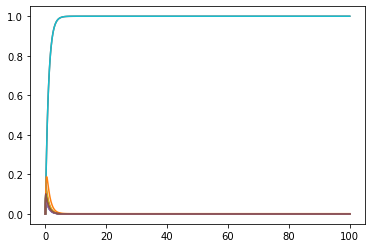

In [16]:
for i in range(16):
    plt.plot(t, y[i,:])
plt.show()

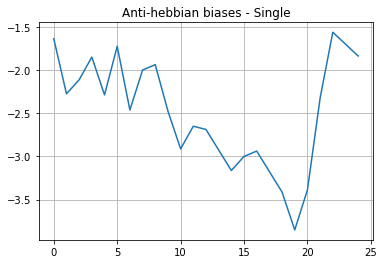

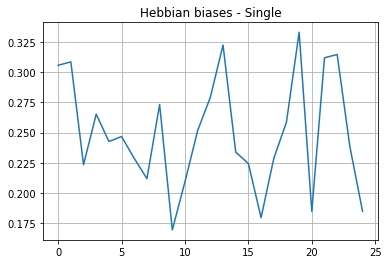

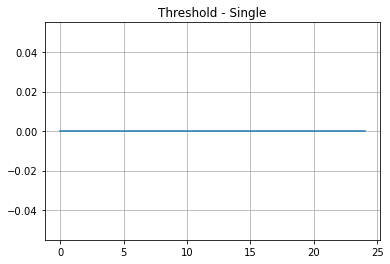

In [17]:
for n in range(1):
    plt.plot([i[1,n] for i in inh_biases])
plt.grid()
plt.title("Anti-hebbian biases - Single")
#plt.savefig("2020_07_10_LEB_wrong_p_inh_single_bias_graph.png")
plt.show()
for n in range(1):
    plt.plot([i[1,n] for i in for_biases])
plt.grid()
plt.title("Hebbian biases - Single")
#plt.savefig("2020_07_10_LEB_wrong_p_for_single_bias_graph.png")
plt.show()
plt.plot([i[1] for i in threses])
plt.grid()
plt.title("Threshold - Single")
#plt.savefig("2020_07_10_LEB_wrong_p_for_single_bias_graph.png")
plt.show()